# Estadística Predictiva y Prescriptiva — Notebook Básico (Python)
**Objetivo:** Introducir de forma sencilla los conceptos de analítica **predictiva** (predecir) y **prescriptiva** (recomendar decisiones) con un ejemplo guiado.
**Duración sugerida:** 1.5–2 horas


## 0) Preparación del entorno

In [3]:

# Si necesitas instalar paquetes localmente, descomenta:
# !pip install scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

np.random.seed(123)


## 1) Dataset simple
Simularemos datos donde **TCH** (rendimiento) depende de lluvia, fertilización y horas de sol. Añadimos ruido para parecer más realista.

In [4]:

n = 140
df = pd.DataFrame({
    'lluvia_mm': np.random.uniform(900, 1800, n),
    'fertilizacion': np.random.uniform(120, 280, n),
    'horas_sol': np.random.uniform(6, 11, n)
})
ruido = np.random.normal(0, 4, n)
df['TCH'] = 0.018*df['lluvia_mm'] + 0.12*df['fertilizacion'] + 0.70*df['horas_sol'] + ruido

df.head()


,lluvia_mm,fertilizacion,horas_sol,TCH
0,1526.822267,134.932274,10.437967,43.400548
1,1157.525401,167.497724,6.080593,45.542521
2,1104.166308,268.413478,6.634790,56.594207
3,1396.183292,211.040597,9.885812,58.095246
4,1547.522073,193.185920,6.229476,51.237689


**Vista rápida del objetivo**

In [5]:

df['TCH'].describe()


count    140.000000
mean      53.506844
std        8.013771
min       28.609734
25%       48.121501
50%       53.072684
75%       59.359686
max       71.455916
Name: TCH, dtype: float64

**Histograma de TCH**

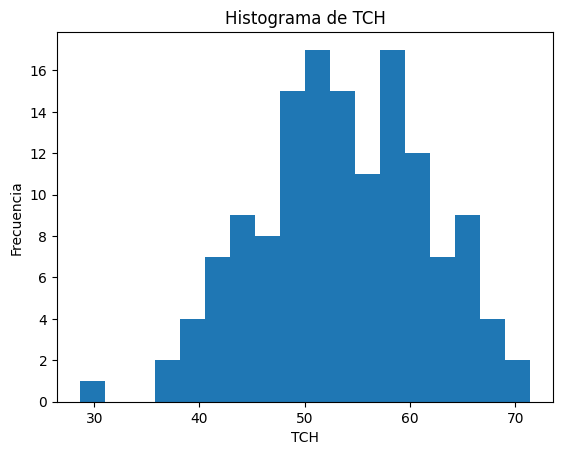

In [6]:

plt.hist(df['TCH'], bins=18)
plt.title('Histograma de TCH')
plt.xlabel('TCH'); plt.ylabel('Frecuencia')
plt.show()


## 2) Analítica Predictiva (Regresión Lineal)
Entrenaremos un modelo sencillo para **predecir TCH** usando las 3 variables. Evaluaremos con **R²** y **MAE** y veremos los **coeficientes** (interpretables).

In [7]:

X = df[['lluvia_mm','fertilizacion','horas_sol']]
y = df['TCH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
print({'R2': round(r2_score(y_test, y_pred), 3), 'MAE': round(mean_absolute_error(y_test, y_pred), 2)})

coef = pd.Series(lr.coef_, index=X.columns)
float(lr.intercept_), coef


{'R2': 0.697, 'MAE': 3.56}


(1.3583806784740133,
 lluvia_mm        0.017039
 fertilizacion    0.121606
 horas_sol        0.627338
 dtype: float64)

**Interpretación simple**
- Un coeficiente positivo sugiere que al **aumentar** esa variable (manteniendo las demás), **sube** el TCH esperado.
- **R²** cercano a 1 implica buen ajuste; **MAE** bajo indica menor error promedio.


## 3) Analítica Prescriptiva (búsqueda sencilla)
Supongamos que puedes decidir **fertilización** y **horas de sol asistidas** (p. ej., riego/iluminación) dentro de un **presupuesto**.
Definimos:
- **Costo** = 2 × fertilización + 30 × horas_sol
- **Beneficio** = precio × TCH_predicha − costo
- Restricción: **costo ≤ presupuesto**

Probamos combinaciones (grid) y elegimos la de **mayor beneficio**.

In [8]:

precio_ton = 35.0
presupuesto = 1100.0

lluvia_fija = df['lluvia_mm'].median()  # supondremos condiciones medias de lluvia

grid_fert = np.linspace(120, 280, 17)   # 17 niveles
grid_sol  = np.linspace(6, 11, 17)      # 17 niveles

print(grid_fert)
mejor = None
resultados = []

for f in grid_fert:
    for hs in grid_sol:
        X_row = pd.DataFrame([[lluvia_fija, f, hs]], columns=['lluvia_mm','fertilizacion','horas_sol'])
        tch_pred = float(lr.predict(X_row)[0])
        costo = 2.0*f + 30.0*hs
        beneficio = precio_ton * tch_pred - costo
        
        if costo <= presupuesto:
            resultados.append((f, hs, tch_pred, costo, beneficio))
            if (mejor is None) or (beneficio > mejor[-1]):
                mejor = (f, hs, tch_pred, costo, beneficio)

mejor, len(resultados)


[120. 130. 140. 150. 160. 170. 180. 190. 200. 210. 220. 230. 240. 250.
 260. 270. 280.]


((np.float64(280.0),
  np.float64(6.0),
  62.42521563225752,
  np.float64(740.0),
  np.float64(1444.8825471290133)),
 289)

**`mejor`** devuelve: `(fertilizacion, horas_sol, TCH_predicho, costo, beneficio)`.
El segundo valor indica cuántas combinaciones cumplieron el presupuesto.

### Mapa simple de beneficio (fertilización vs horas de sol)

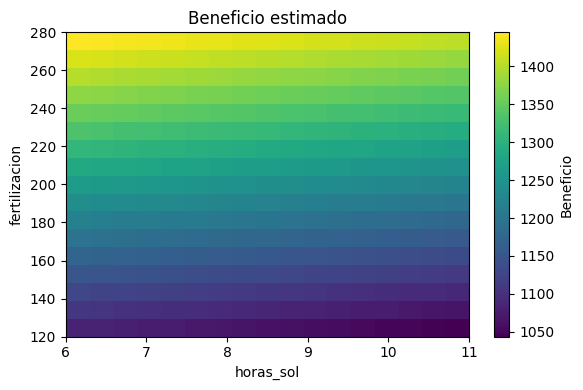

In [9]:

if len(resultados) > 0:
    M = pd.DataFrame(resultados, columns=['fertilizacion','horas_sol','TCH_pred','costo','beneficio'])
    pivot = M.pivot_table(index='fertilizacion', columns='horas_sol', values='beneficio')
    plt.figure(figsize=(6,4))
    plt.imshow(pivot.values, aspect='auto', origin='lower',
               extent=[pivot.columns.min(), pivot.columns.max(), pivot.index.min(), pivot.index.max()])
    plt.colorbar(label='Beneficio')
    plt.xlabel('horas_sol'); plt.ylabel('fertilizacion')
    plt.title('Beneficio estimado')
    plt.tight_layout()
    plt.show()
    
    M.sort_values('beneficio', ascending=False).head()
else:
    print("No hay escenarios dentro del presupuesto. Ajusta el presupuesto o los costos.")


##### Resumen en una frase

- R² = 0.697: el modelo explica aproximadamente el 69.7% de la variación del TCH en los datos.
- MAE = 3.56: en promedio las predicciones se equivocan 3.56 unidades de TCH.

##### Explicación en lenguaje sencillo 

- R² (“R al cuadrado”): imagina que quieres explicar por qué unas parcelas rinden más que otras. R² = 0.697 significa que nuestro modelo captura casi 7 de cada 10 razones por las que el rendimiento cambia. No es perfecto, pero sí captura la mayor parte del patrón.
- MAE (error absoluto medio): si decimos MAE = 3.56, quiere decir que, en promedio, nuestras predicciones están a 3.56 TCH del valor real. Es una medida directa y fácil de entender: “nos equivocamos, de media, X unidades”.